In [1]:
#import geopandas
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os, os.path
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from ipynb.fs.full.interp_data import interpolate_scenario_data

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
sns.set_style("ticks")

In [4]:
C1_c = "#649B1C"
C2_c = "#00B593"
C3_c = "#4E84D4"

In [5]:
ems_fac = (101.2+94.6)/2 # tCO2/TJ

In [6]:
crosswalk = pd.read_excel("../../data/MESSAGE/mapping_file_R10edit.xlsx",sheet_name="main")
AR6_list = crosswalk["AR6_R10"].unique()
crosswalk.head()

,Countries,R10,AR6_R10,GEM_Name,ISO
0,Algeria,Africa (R10),R10AFRICA,Algeria,DZA
1,Angola,Africa (R10),R10AFRICA,Angola,AGO
2,Benin,Africa (R10),R10AFRICA,NaN,BEN
3,Botswana,Africa (R10),R10AFRICA,NaN,BWA
4,Burkina Faso,Africa (R10),R10AFRICA,NaN,BFA


In [7]:
# load data
ar6_world = pd.read_csv("../../data/AR6_data/1668008174375-AR6_Scenarios_Database_R10_regions_v1.1.csv/AR6_Scenarios_Database_R10_regions_v1.1.csv")
ar6_scen = pd.read_excel("../../data/AR6_data/AR6_Scenarios_Database_World_v1.1/AR6_Scenarios_Database_metadata_indicators_v1.1.xlsx",sheet_name = "meta_Ch3vetted_withclimate")

In [8]:
ar6_scen_123 = ar6_scen[ar6_scen["Category"].isin(["C1","C2","C3"])]

In [9]:
# unit in EJ
# EJ/yr x 10^6 TJ/EJ x tCO2/TJ x 1MtCO2/10^6 tCO2
ar6_coal_gen = ar6_world.query("Variable=='Primary Energy|Coal|Electricity|w/o CCS'")#Capacity|Electricity|Coal|w/o CCS
ar6_coal_gen = interpolate_scenario_data(ar6_coal_gen)
ar6_coal_gen = pd.merge(ar6_coal_gen,ar6_scen_123[["Model","Scenario","Category"]],
                                  left_on=["Model","Scenario"],right_on=["Model","Scenario"])
ar6_coal_gen_melt = pd.melt(ar6_coal_gen,id_vars=["Model","Scenario","Category","Region"],value_vars=ar6_coal_gen.columns[5:-1],
                             var_name="Year",value_name="CoalGen_EJ/yr").dropna()
ar6_coal_gen_melt["Year"] = ar6_coal_gen_melt["Year"].astype(int)
ar6_coal_gen_melt = ar6_coal_gen_melt.sort_values("Category")
ar6_coal_gen_melt = ar6_coal_gen_melt[ar6_coal_gen_melt["Year"]>=2020]
ar6_coal_gen_melt["MtCO2/yr"] = ar6_coal_gen_melt["CoalGen_EJ/yr"] *ems_fac
ar6_coal_gen_melt

,Model,Scenario,Category,Region,Year,CoalGen_EJ/yr,MtCO2/yr
187997,IMAGE 3.2,SSP1_SPA1_19I_LIRE_LB,C1,R10NORTH_AM,2064,0.018641,1.824946
223529,REMIND-MAgPIE 2.1-4.2,NGFS2_Net-Zero 2050,C1,R10REF_ECON,2079,0.000100,0.009790
223528,REMIND-MAgPIE 2.1-4.2,NGFS2_Net-Zero 2050,C1,R10PAC_OECD,2079,0.000190,0.018601
223527,REMIND-MAgPIE 2.1-4.2,NGFS2_Net-Zero 2050,C1,R10NORTH_AM,2079,0.000190,0.018601
223526,REMIND-MAgPIE 2.1-4.2,NGFS2_Net-Zero 2050,C1,R10MIDDLE_EAST,2079,0.000100,0.009790
...,...,...,...,...,...,...,...
163369,MESSAGEix-GLOBIOM_1.1,EN_NPi2020_1000f_DR3p,C3,R10AFRICA,2053,0.000000,0.000000
163370,MESSAGEix-GLOBIOM_1.1,EN_NPi2020_1000f_DR3p,C3,R10CHINA+,2053,0.000000,0.000000
163371,MESSAGEix-GLOBIOM_1.1,EN_NPi2020_1000f_DR3p,C3,R10EUROPE,2053,0.000000,0.000000
163372,MESSAGEix-GLOBIOM_1.1,EN_NPi2020_1000f_DR3p,C3,R10INDIA+,2053,0.000000,0.000000


### coal fleet data

In [76]:
com_coal = pd.read_csv("../../data/global_GEM/analysis_plant/coal_plant_current_commited.csv")
com_coal_sum = pd.merge(com_coal,crosswalk[["GEM_Name","AR6_R10"]],left_on="Country",right_on="GEM_Name")
com_coal_sum = com_coal_sum.groupby(["Year","AR6_R10"]).sum()[["AnnualMtCO2","MWh/yr","MW"]]
com_coal_sum_ex = com_coal_sum.copy()
com_coal_sum_ex.to_csv("coal_committed.csv")
com_coal_sum = com_coal_sum.reset_index()
com_coal_sum

,Year,AR6_R10,AnnualMtCO2,MWh/yr,MW
0,2023,R10AFRICA,255.2,2.385754e+08,51386.10
1,2023,R10CHINA+,5089.5,5.223531e+09,1125082.00
2,2023,R10EUROPE,706.1,6.297209e+08,135633.86
3,2023,R10INDIA+,1144.3,1.146571e+09,246956.70
4,2023,R10LATIN_AM,84.3,7.657834e+07,16494.00
...,...,...,...,...,...
384,2068,R10AFRICA,24.8,2.959321e+07,6374.00
385,2069,R10AFRICA,18.6,2.221301e+07,4784.40
386,2070,R10AFRICA,15.5,1.852291e+07,3989.60
387,2071,R10AFRICA,9.3,1.111858e+07,2394.80


In [77]:
hist_coal = pd.read_csv("../../data/global_GEM/analysis_plant/coal_plant_annual_summary.csv")
hist_coal_sum = pd.merge(hist_coal,crosswalk[["GEM_Name","AR6_R10"]],left_on="Country",right_on="GEM_Name")
hist_coal_sum = hist_coal_sum.groupby(["Year","AR6_R10"]).sum()[["AnnualMtCO2","MWh/yr","MW"]]
hist_coal_sum = pd.concat([hist_coal_sum,com_coal_sum_ex.loc[[2023]]])
hist_coal_sum.to_csv("coal_historical.csv")
hist_coal_sum = hist_coal_sum.reset_index()
hist_coal_sum

,Year,AR6_R10,AnnualMtCO2,MWh/yr,MW
0,1927,R10EUROPE,0.2,1.671408e+05,36.00
1,1928,R10EUROPE,0.2,1.671408e+05,36.00
2,1929,R10EUROPE,0.2,1.671408e+05,36.00
3,1930,R10EUROPE,0.2,1.671408e+05,36.00
4,1931,R10EUROPE,0.2,1.671408e+05,36.00
...,...,...,...,...,...
720,2023,R10MIDDLE_EAST,22.3,2.035868e+07,4385.00
721,2023,R10NORTH_AM,1100.5,1.004298e+09,216313.06
722,2023,R10PAC_OECD,382.5,3.645711e+08,78523.98
723,2023,R10REF_ECON,488.4,3.992135e+08,85985.50


In [69]:
for current_type in ["low","mid","high"]:
    const_coal = pd.read_csv("../../data/global_GEM/analysis_plant/coal_plant_construction_"+current_type+".csv")
    const_coal = pd.merge(const_coal,crosswalk[["GEM_Name","AR6_R10"]],left_on="Country",right_on="GEM_Name")
    const_coal = const_coal.groupby(["Year","AR6_R10","Type"]).sum()
    const_coal = const_coal.reset_index().drop(columns=["Country","GEM_Name"])
    const_coal_add = pd.concat([const_coal,com_coal_sum])
    const_coal_add["GW"] = const_coal_add["MW"]/1000
    const_coal_add = const_coal_add.groupby(["Year","AR6_R10"]).sum()
    const_coal_add["Type"] = "Construction_"+current_type
    if current_type == "low":
        const_coal_all = const_coal_add
    else:
        const_coal_all = pd.concat([const_coal_all,const_coal_add])
        
    # reconstruct to fill the gaps
    const_plants_restru = const_coal_all.copy().reset_index()
    for this_year in const_plants_restru["Year"].unique():
        for this_type in const_plants_restru["Type"].unique():
            this_year_const = const_plants_restru[const_plants_restru["Year"]==this_year]
            this_year_const = this_year_const[this_year_const["Type"]==this_type]
            if len(this_year_const)<len(AR6_list):
                this_year_countries = this_year_const["AR6_R10"]
                missing_countries = list(set(AR6_list) - set(this_year_countries))
                adding_rows = pd.DataFrame(data={"AR6_R10":missing_countries,"Year":this_year,"Type":this_type})
                const_plants_restru = pd.concat([const_plants_restru,adding_rows])
const_plants_restru = const_plants_restru.fillna(0)
const_plants_restru.to_csv("coal_construction.csv")
const_plants_restru

,Year,AR6_R10,Type,MW,AnnualMtCO2,MWh/yr,GW
0,2023,R10AFRICA,Construction_low,51386.10,255.2,2.385754e+08,51.38610
1,2023,R10CHINA+,Construction_low,1125082.00,5089.5,5.223531e+09,1125.08200
2,2023,R10EUROPE,Construction_low,135633.86,706.1,6.297209e+08,135.63386
3,2023,R10INDIA+,Construction_low,246956.70,1144.3,1.146571e+09,246.95670
4,2023,R10LATIN_AM,Construction_low,16494.00,84.3,7.657834e+07,16.49400
...,...,...,...,...,...,...,...
6,2074,R10EUROPE,Construction_mid,0.00,0.0,0.000000e+00,0.00000
7,2074,R10LATIN_AM,Construction_mid,0.00,0.0,0.000000e+00,0.00000
8,2074,R10REF_ECON,Construction_mid,0.00,0.0,0.000000e+00,0.00000
9,2074,R10PAC_OECD,Construction_mid,0.00,0.0,0.000000e+00,0.00000


### plot

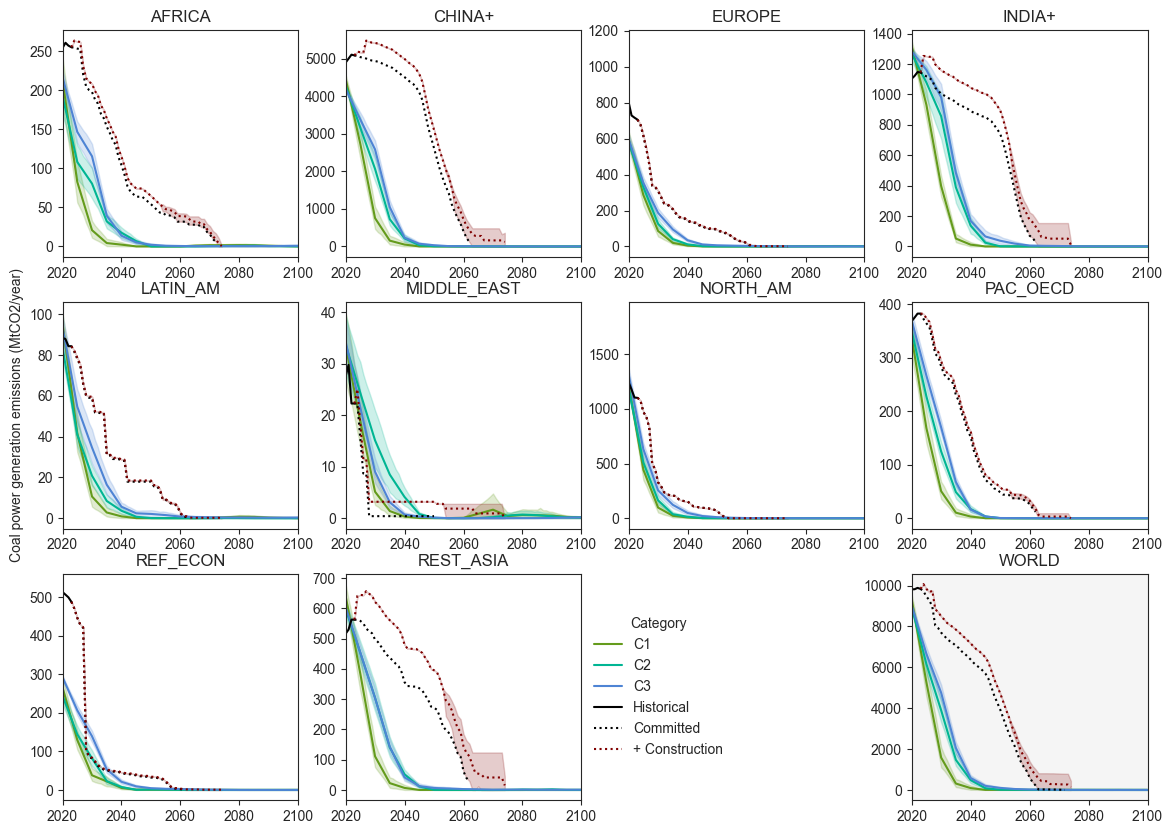

In [79]:
fig, axes = plt.subplots(3,4,figsize=(14,10))
row_list = [0,0,0,0,1,1,1,1,2,2,2]
col_list = [0,1,2,3,0,1,2,3,0,1,3]
plot_type = "hist" # "hist" "2050"

#sum_com_gas_all_p = sum_com_gas_all.reset_index()
#aged_gas_p = aged_gas_all.reset_index()
const_coal_all_p = const_plants_restru.reset_index()

for n_r10 in np.arange(len(AR6_list)+1):
    this_ax = axes[row_list[n_r10],col_list[n_r10]]
    
    if n_r10<10: # separate R10 regions
        r10 = AR6_list[n_r10]
        ar6_world_coal_r = ar6_coal_gen_melt[ar6_coal_gen_melt["Region"]==r10]
        committed_coal = com_coal_sum[com_coal_sum["AR6_R10"]==r10]
        historical_coal = hist_coal_sum[hist_coal_sum["AR6_R10"]==r10]
        construction_coal = const_coal_all_p[const_coal_all_p["AR6_R10"]==r10]
    else: # summarize data in the wolrd
        r10 = "R10WORLD"
        ar6_world_coal_r = ar6_coal_gen_melt.groupby(["Year","Model","Scenario","Category"]).sum()[["MtCO2/yr"]]
        ar6_world_coal_r = ar6_world_coal_r.sort_values("Category")
        historical_coal = hist_coal_sum.groupby("Year").sum()[["AnnualMtCO2"]]
        committed_coal = com_coal_sum.groupby("Year").sum()[["AnnualMtCO2"]]
        construction_coal = const_coal_all_p.groupby(["Year","Type"]).sum()[["AnnualMtCO2"]]

    #this_ax.vlines(x = 2023, ymin = committed_gas.query("Year==2023")["GW"],
    #               ymax = historical_gas.query("Year==2023")["GW"], color="orange",linestyle=":",label="Over aged")
    sns.lineplot(x='Year', y='MtCO2/yr', hue='Category', data=ar6_world_coal_r,palette=[C1_c,C2_c,C3_c],ax=this_ax)
    sns.lineplot(x='Year', y='AnnualMtCO2', data=historical_coal,ax=this_ax,color="black",label="Historical")
    sns.lineplot(x='Year', y='AnnualMtCO2', data=committed_coal,ax=this_ax,color="black",label="Committed",linestyle=":")
    sns.lineplot(x='Year', y='AnnualMtCO2', data=construction_coal,ax=this_ax,color="maroon",label="+ Construction",linestyle=":")

    this_ax.set_xlabel(None)
    this_ax.set_title(r10[3:])
    if n_r10 == 9:
        this_ax.legend(title = 'Category', loc='center left', bbox_to_anchor=(1, 0.5),frameon=False)
    else:
        this_ax.get_legend().remove()
        
    if n_r10 == 4 :
        this_ax.set_ylabel("Coal power generation emissions (MtCO2/year)")
    else:
        this_ax.set_ylabel(None)
    
    if n_r10 == 10:
        this_ax.set_facecolor('whitesmoke')
        
    if plot_type == "hist":
        this_ax.set_xlim([2020,2100])
    elif plot_type == "2050":
        this_ax.set_xlim([2020,2050])
    
fig.delaxes(axes[2,2])
fig.savefig("committed_coal_ems_"+plot_type+"_R10.png",dpi=600, bbox_inches='tight')